# 0.0 Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import xgboost as xgb
from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


#Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport

#Others
import pickle
import warnings

from IPython.display       import Image
from IPython.core.display  import HTML

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)


def diagnostic_plots(df, variable):
    # plot the histograms to have a quick look at the distributions
    # we can plot Q-Q plots to visualise if the variable is normally distributed
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()
    

jupyter_settings()

## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('csv/train.csv',low_memory=False)
test_raw = pd.read_csv('csv/test.csv',low_memory=False)

# 1.0. Descrição dos Dados

In [4]:
df_raw.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid,bank_account
0,Rwanda,2016,uniqueid_4858,Rural,Yes,6,45,Male,Head of Household,Divorced/Seperated,Primary education,Farming and Fishing,Rwanda_uniqueid_4858,No
1,Tanzania,2017,uniqueid_3015,Urban,No,4,33,Female,Head of Household,Single/Never Married,Primary education,Self employed,Tanzania_uniqueid_3015,No
2,Rwanda,2016,uniqueid_103,Rural,Yes,7,43,Male,Head of Household,Married/Living together,Secondary education,Farming and Fishing,Rwanda_uniqueid_103,No
3,Rwanda,2016,uniqueid_4582,Rural,No,6,35,Female,Head of Household,Married/Living together,Primary education,Farming and Fishing,Rwanda_uniqueid_4582,No
4,Tanzania,2017,uniqueid_2854,Urban,Yes,2,30,Male,Head of Household,Single/Never Married,Primary education,Informally employed,Tanzania_uniqueid_2854,No


## 1.1. Data Dimensions and Columns

In [5]:
print(f'number of rows: {df_raw.shape[0]}')
print(f'number of columns: {df_raw.shape[1]}')

#df_raw.columns  # already in snake case! :)

number of rows: 11762
number of columns: 14


## 1.2. Data Types

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11762 entries, 0 to 11761
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 11762 non-null  object
 1   year                    11762 non-null  int64 
 2   uniqueid                11762 non-null  object
 3   location_type           11762 non-null  object
 4   cellphone_access        11762 non-null  object
 5   household_size          11762 non-null  int64 
 6   age_of_respondent       11762 non-null  int64 
 7   gender_of_respondent    11762 non-null  object
 8   relationship_with_head  11762 non-null  object
 9   marital_status          11762 non-null  object
 10  education_level         11762 non-null  object
 11  job_type                11762 non-null  object
 12  uid                     11762 non-null  object
 13  bank_account            11762 non-null  object
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


## 1.3. Check NA

In [7]:
df_raw.isna().sum()

country                   0
year                      0
uniqueid                  0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
uid                       0
bank_account              0
dtype: int64

## 1.4 EDA

In [8]:
#EDA using pandas-profiling
profile = ProfileReport(df_raw, explorative=True)

#Saving results to a HTML file
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 2.0 FEATURE ENGINEERING

In [9]:
df1 = df_raw.copy()
df1.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid,bank_account
0,Rwanda,2016,uniqueid_4858,Rural,Yes,6,45,Male,Head of Household,Divorced/Seperated,Primary education,Farming and Fishing,Rwanda_uniqueid_4858,No
1,Tanzania,2017,uniqueid_3015,Urban,No,4,33,Female,Head of Household,Single/Never Married,Primary education,Self employed,Tanzania_uniqueid_3015,No
2,Rwanda,2016,uniqueid_103,Rural,Yes,7,43,Male,Head of Household,Married/Living together,Secondary education,Farming and Fishing,Rwanda_uniqueid_103,No
3,Rwanda,2016,uniqueid_4582,Rural,No,6,35,Female,Head of Household,Married/Living together,Primary education,Farming and Fishing,Rwanda_uniqueid_4582,No
4,Tanzania,2017,uniqueid_2854,Urban,Yes,2,30,Male,Head of Household,Single/Never Married,Primary education,Informally employed,Tanzania_uniqueid_2854,No


In [10]:
def idade(coluna):
    if coluna <= 26:
        return "Jovem"
    elif 26<coluna<=35:
        return "Jovem_Adulto"
    elif 35<coluna<=48:
        return "Adulto"
    else:
        return "Velho"

In [11]:
df1['age_of_respondent'] = df1['age_of_respondent'].map(idade)

## 2.1 Encoding Variables

In [12]:
df1['bank_account'] = df1['bank_account'].apply(lambda x: 1 if x=='Yes' else 0)
df1['gender_of_respondent'] = df1['gender_of_respondent'].apply(lambda x: 1 if x=='Male' else 0)
df1['location_type'] = df1['location_type'].apply(lambda x:1 if x=='Rural' else 0)
df1['cellphone_access'] = df1['cellphone_access'].apply(lambda x:1 if x=='Yes' else 0)

df1 = pd.get_dummies(df1, columns=['relationship_with_head'], prefix = ['rwh'])
df1 = pd.get_dummies(df1, columns=['age_of_respondent'], prefix = ['aor'])
df1 = pd.get_dummies(df1, columns=['marital_status'], prefix = ['ms'])
df1 = pd.get_dummies(df1, columns=['job_type'], prefix = ['jt'])
df1 = pd.get_dummies(df1, columns=['country'], prefix = ['c'])
#Label Encoder
df1['education_level'] = LabelEncoder().fit_transform(df1['education_level'].astype(str))


In [13]:
df1['household_size'] = np.log(df1.household_size)

In [14]:
df1.head()

,year,uniqueid,location_type,cellphone_access,household_size,gender_of_respondent,education_level,uid,bank_account,rwh_Child,rwh_Head of Household,rwh_Other non-relatives,rwh_Other relative,rwh_Parent,rwh_Spouse,aor_Adulto,aor_Jovem,aor_Jovem_Adulto,aor_Velho,ms_Divorced/Seperated,ms_Dont know,ms_Married/Living together,ms_Single/Never Married,ms_Widowed,jt_Dont Know/Refuse to answer,jt_Farming and Fishing,jt_Formally employed Government,jt_Formally employed Private,jt_Government Dependent,jt_Informally employed,jt_No Income,jt_Other Income,jt_Remittance Dependent,jt_Self employed,c_Kenya,c_Rwanda,c_Tanzania,c_Uganda
0,2016,uniqueid_4858,1,1,1.791759,1,2,Rwanda_uniqueid_4858,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2017,uniqueid_3015,0,0,1.386294,0,2,Tanzania_uniqueid_3015,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2016,uniqueid_103,1,1,1.945910,1,3,Rwanda_uniqueid_103,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,2016,uniqueid_4582,1,0,1.791759,0,2,Rwanda_uniqueid_4582,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,2017,uniqueid_2854,0,1,0.693147,1,2,Tanzania_uniqueid_2854,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [15]:
df1.dtypes

year                                 int64
uniqueid                            object
location_type                        int64
cellphone_access                     int64
household_size                     float64
gender_of_respondent                 int64
education_level                      int64
uid                                 object
bank_account                         int64
rwh_Child                            uint8
rwh_Head of Household                uint8
rwh_Other non-relatives              uint8
rwh_Other relative                   uint8
rwh_Parent                           uint8
rwh_Spouse                           uint8
aor_Adulto                           uint8
aor_Jovem                            uint8
aor_Jovem_Adulto                     uint8
aor_Velho                            uint8
ms_Divorced/Seperated                uint8
ms_Dont know                         uint8
ms_Married/Living together           uint8
ms_Single/Never Married              uint8
ms_Widowed 

# 3.0 Data Preparation

In [17]:
df2 = df1.copy()

## 3.1. Split dataframe  into training and testing

In [18]:
Y = df2['bank_account'].copy()
X = df2.drop(['uniqueid', 'bank_account','uid'],axis=1)

In [19]:
X_train, X_test, y_train,y_test = train_test_split(X,Y,train_size=0.75,stratify=Y,random_state=123)

## 3.2 Seleção de Features

In [20]:
# Treinando modelo
model  = RandomForestClassifier()
model.fit(X_train, y_train)# Mostrando importância de cada feature
model_feature_importances = model.feature_importances_
model_feature_importances

array([1.81059572e-02, 5.76606163e-02, 3.67038633e-02, 2.12904431e-01,
       3.38488925e-02, 1.87796772e-01, 7.89678116e-03, 2.02672850e-02,
       3.40716520e-03, 5.51392977e-03, 5.33400810e-03, 1.15554030e-02,
       2.24611474e-02, 2.33584477e-02, 2.46371253e-02, 2.12526067e-02,
       1.07738111e-02, 8.56214664e-05, 1.89144317e-02, 1.77110546e-02,
       9.61500921e-03, 3.25741768e-03, 1.92140005e-02, 3.30789640e-02,
       5.34035849e-02, 4.62330658e-03, 2.25539218e-02, 2.30278375e-03,
       1.46753220e-02, 1.51380940e-02, 2.55715429e-02, 3.01615329e-02,
       7.61495155e-03, 1.02326040e-02, 8.36761397e-03])

Text(0.5, 1.0, 'Importância de cada feature')

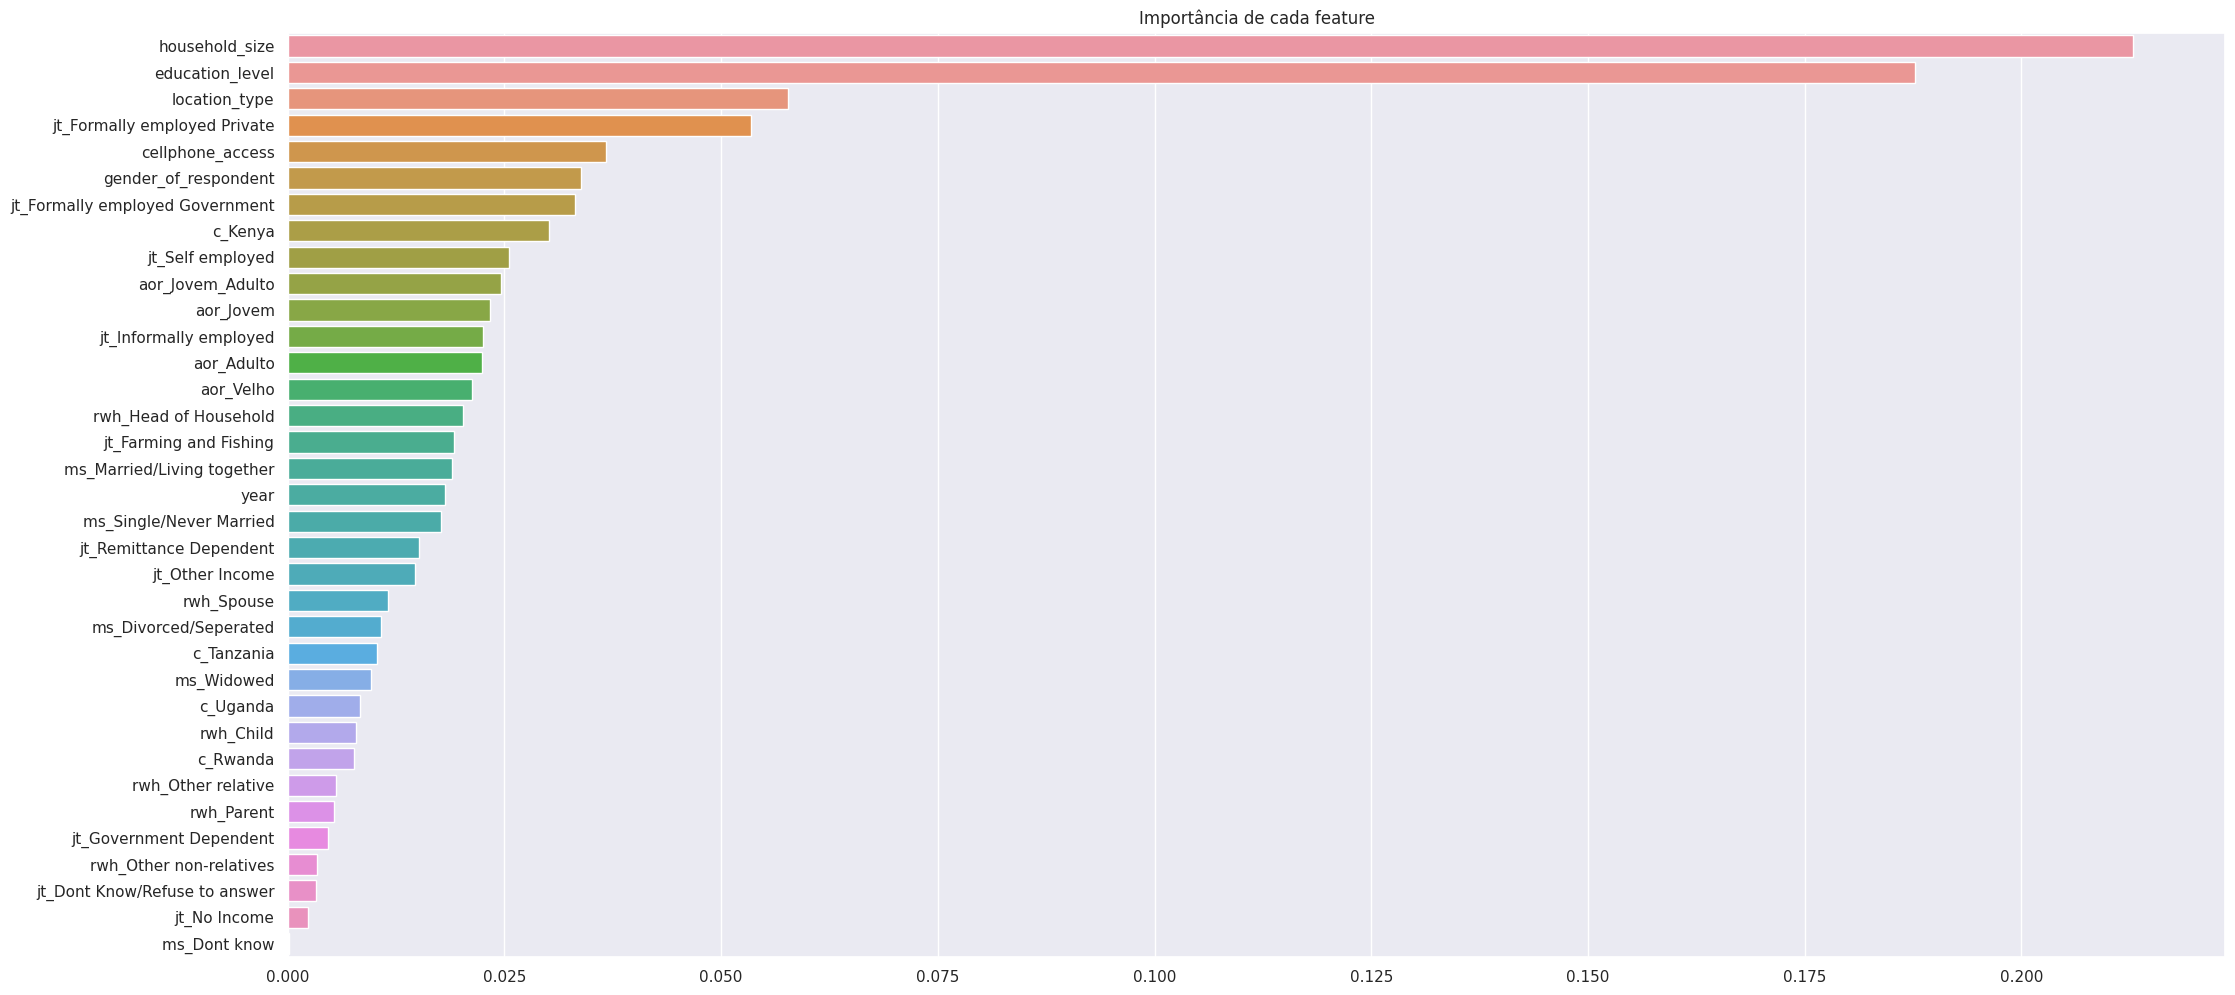

In [21]:
df_feat = df1.drop(['uniqueid', 'bank_account','uid'],axis=1)
importances = pd.Series(model_feature_importances, index=df_feat.columns)
importances = importances.sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [22]:
importances

household_size                     0.212904
education_level                    0.187797
location_type                      0.057661
jt_Formally employed Private       0.053404
cellphone_access                   0.036704
gender_of_respondent               0.033849
jt_Formally employed Government    0.033079
c_Kenya                            0.030162
jt_Self employed                   0.025572
aor_Jovem_Adulto                   0.024637
aor_Jovem                          0.023358
jt_Informally employed             0.022554
aor_Adulto                         0.022461
aor_Velho                          0.021253
rwh_Head of Household              0.020267
jt_Farming and Fishing             0.019214
ms_Married/Living together         0.018914
year                               0.018106
ms_Single/Never Married            0.017711
jt_Remittance Dependent            0.015138
jt_Other Income                    0.014675
rwh_Spouse                         0.011555
ms_Divorced/Seperated           

In [23]:
cols_selected = ['household_size', 'education_level', 'location_type', 'jt_Formally employed Private', 'cellphone_access', 'gender_of_respondent', 'jt_Formally employed Government',
                 'c_Kenya', 'jt_Self employed', 'aor_Jovem_Adulto', 'aor_Jovem', 'aor_Adulto', 'rwh_Head of Household', 'jt_Informally employed','aor_Velho']

In [24]:
X_train = X_train[cols_selected]
X_test = X_test[cols_selected]

In [25]:
X_train.columns = ['household_size', 'education_level', 'location_type',
       'jt_formally_employed_private', 'cellphone_access',
       'gender_of_respondent', 'jt_formally_employed_government', 'c_kenya',
       'jt_self_employed', 'aor_jovem_adulto', 'aor_jovem', 'aor_adulto',
       'rwh_head_of_household', 'jt_informally_employed', 'aor_Velho']

X_test.columns = ['household_size', 'education_level', 'location_type',
       'jt_formally_employed_private', 'cellphone_access',
       'gender_of_respondent', 'jt_formally_employed_government', 'c_kenya',
       'jt_self_employed', 'aor_jovem_adulto', 'aor_jovem', 'aor_adulto',
       'rwh_head_of_household', 'jt_informally_employed', 'aor_Velho']

# 4.0 Machine Learning

In [26]:
clf =  RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.55, min_samples_leaf=9, min_samples_split=12, n_estimators=200)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=0.55,
                       min_samples_leaf=9, min_samples_split=12,
                       n_estimators=200)

In [27]:
y_pred=clf.predict(X_test)
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
print("F1: %.2f%%" % (f1_score(y_test, y_pred)*100))

Accuracy: 88.34%
F1: 46.32%


In [28]:
model1 = xgb.XGBClassifier()
model2 = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)
model3 = xgb.XGBClassifier(learning_rate= 0.01,
                            n_estimators=1500,
                            max_depth= 4,
                            subsample= 0.8,
                            colsample_bytree= 1,
                            gamma= 1)

In [29]:
model1.fit(X_train, y_train)
y_pred=model1.predict(X_test)

print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
print("F1: %.2f%%" % (f1_score(y_test, y_pred)*100))

Accuracy: 87.86%
F1: 44.99%


In [30]:
model2.fit(X_train, y_train)
y_pred=model2.predict(X_test)

print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
print("F1: %.2f%%" % (f1_score(y_test, y_pred)*100))

Accuracy: 87.86%
F1: 45.33%


In [31]:
model3.fit(X_train, y_train)
y_pred=model3.predict(X_test)

print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
print("F1: %.2f%%" % (f1_score(y_test, y_pred)*100))

Accuracy: 88.54%
F1: 45.56%


# 5.0 Test Submission

In [32]:
test = test_raw.copy()

In [33]:
test.sample()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid
10901,Rwanda,2016,uniqueid_1736,Rural,Yes,3,50,Male,Head of Household,Single/Never Married,Secondary education,Farming and Fishing,Rwanda_uniqueid_1736


## 5.1 Variable Encoding

In [34]:
test['age_of_respondent'] = test['age_of_respondent'].map(idade)

In [35]:

test['gender_of_respondent']=test['gender_of_respondent'].apply(lambda x: 1 if x=='Male' else 0)
test['location_type']=test['location_type'].apply(lambda x:1 if x=='Rural' else 0)
test['cellphone_access']=test['cellphone_access'].apply(lambda x:1 if x=='Yes' else 0)

test = pd.get_dummies(test, columns=['relationship_with_head'], prefix = ['rwh'])
test = pd.get_dummies(test, columns=['age_of_respondent'], prefix = ['aor'])

test = pd.get_dummies(test, columns=['marital_status'], prefix = ['ms'])
test = pd.get_dummies(test, columns=['job_type'], prefix = ['jt'])
test = pd.get_dummies(test, columns=['country'], prefix = ['c'])

test['education_level'] = LabelEncoder().fit_transform(test['education_level'].astype(str))


In [36]:
test['household_size'] = np.log(test.household_size)

## 5.2 Feature Selection

In [37]:
df_test = test[cols_selected]
df_test.columns = ['household_size', 'education_level', 'location_type',
       'jt_formally_employed_private', 'cellphone_access',
       'gender_of_respondent', 'jt_formally_employed_government', 'c_kenya',
       'jt_self_employed', 'aor_jovem_adulto', 'aor_jovem', 'aor_adulto',
       'rwh_head_of_household', 'jt_informally_employed', 'aor_Velho']

## 5.2 Training Model

In [38]:
# Make a prediction using the XGboost model on the wanted columns
predictions = model3.predict(df_test)

In [39]:
submission = pd.DataFrame({'uid': test.uid, 'bank_account': predictions})

In [40]:
submission.dtypes

uid             object
bank_account     int64
dtype: object

In [41]:
submission['bank_account'].value_counts()

0    10952
1      810
Name: bank_account, dtype: int64

In [42]:
def yesno(coluna):
    if coluna == 0:
        return "No"
    else:
        return "Yes"

In [43]:
submission['bank_account'] = submission['bank_account'].map(yesno)

In [44]:
submission.sample(100)

,uid,bank_account
6258,Kenya_uniqueid_3580,No
7431,Kenya_uniqueid_3380,No
2173,Kenya_uniqueid_425,No
5310,Tanzania_uniqueid_5889,No
715,Rwanda_uniqueid_821,No
252,Rwanda_uniqueid_1953,No
7231,Rwanda_uniqueid_2984,No
7806,Tanzania_uniqueid_5379,No
2941,Rwanda_uniqueid_6726,No
5395,Rwanda_uniqueid_6725,No


In [ ]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('/kaggle/working/submission.csv', index=False)
print('Submission CSV is ready!')